<a href="https://colab.research.google.com/github/cemredogan-ceng/BUSI/blob/main/busi_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install necessary libraries
!pip install segmentation-models-pytorch
!pip install torch torchvision
!pip install scikit-learn

# Import libraries
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image, ImageEnhance
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Mount Google Drive
drive.mount('/content/drive')

# Dataset directory
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Custom Dataset Class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, classes=['benign', 'malignant'], transform_image=None, transform_mask=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.image_paths = []
        self.mask_paths = []

        # Load image and mask paths
        for cls in self.classes:
            image_dir = os.path.join(root_dir, cls)
            for filename in os.listdir(image_dir):
                if filename.endswith(".png") and "_mask" not in filename:
                    image_path = os.path.join(image_dir, filename)
                    mask_path = os.path.join(image_dir, filename.replace(".png", "_mask.png"))
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask

        # Apply data augmentations
        if np.random.rand() > 0.5:
            image = ImageEnhance.Contrast(image).enhance(1.5)  # Increase contrast
        if np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        if np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)  # Vertical flip
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Image and mask transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = BreastUltrasoundDataset(
    root_dir=base_dir,
    classes=['benign', 'malignant'],
    transform_image=transform_image,
    transform_mask=transform_mask
)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Define CNN-RNN-based segmentation model
class CNNRNN_SegmentationModel(nn.Module):
    def __init__(self, cnn_weights=ResNet34_Weights.IMAGENET1K_V1, num_classes=1):
        super(CNNRNN_SegmentationModel, self).__init__()
        # CNN encoder: ResNet34
        self.encoder = resnet34(weights=cnn_weights)
        self.encoder.avgpool = nn.Identity()  # Remove global average pooling
        self.encoder.fc = nn.Identity()  # Remove the fully connected layer

        # RNN: LSTM
        self.rnn = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)

        # Decoder head
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),  # Match input size
            nn.Conv2d(64, num_classes, kernel_size=1),  # Final output
        )

    def forward(self, x):
        # CNN encoder
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)  # Resize for ResNet
        features = self.encoder(x)  # Shape: [batch_size, 512, 7, 7]

        # Ensure the encoder output has 4 dimensions
        if len(features.shape) == 2:  # If flattened, reshape to 4D
            batch_size = features.size(0)
            features = features.view(batch_size, 512, 7, 7)

        # Flatten spatial dimensions for RNN input
        batch_size, channels, height, width = features.size()
        rnn_input = features.view(batch_size, channels, height * width).permute(0, 2, 1)  # [batch_size, seq_len, features]

        # RNN
        rnn_output, _ = self.rnn(rnn_input)  # Shape: [batch_size, seq_len, hidden_size * 2]
        rnn_output = rnn_output.permute(0, 2, 1).view(batch_size, -1, height, width)  # [batch_size, features, height, width]

        # Decoder
        decoded = self.decoder(rnn_output)
        decoded = F.interpolate(decoded, size=(256, 256), mode="bilinear", align_corners=True)  # Match target size

        return decoded

# Initialize the model
model = CNNRNN_SegmentationModel(cnn_weights=ResNet34_Weights.DEFAULT, num_classes=1).cuda()

# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/cnn_rnn_segmentation_model.pth')

# Evaluation function
def evaluate_model(dataset, model, num_samples=100):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, mask = dataset[i]
            image = image.unsqueeze(0).cuda()  # Add batch dimension
            mask = mask.squeeze().cpu().numpy()  # Ground truth mask in NumPy format

            # Get model prediction
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Apply sigmoid activation

            # Binarize the prediction with a threshold of 0.5
            prediction_binary = (prediction > 0.5).astype(np.uint8)

            # Flatten the arrays for metric computation
            all_preds.append(prediction_binary.flatten())
            all_masks.append(mask.flatten())

    # Concatenate all predictions and masks
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    # Dice score
    intersection = np.logical_and(y_true, y_pred).sum()
    dice_score = (2.0 * intersection) / (y_true.sum() + y_pred.sum() + 1e-6)

    # IoU (Jaccard Index)
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / (union + 1e-6)

    # Print metrics
    print("Evaluation Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Dice Score: {dice_score:.4f}")
    print(f"  IoU (Jaccard Index): {iou:.4f}")

# Evaluate the entire dataset
evaluate_model(dataset, model, num_samples=len(dataset))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20, Loss: 0.39004185214275267
Epoch 2/20, Loss: 0.21072755717649694
Epoch 3/20, Loss: 0.16023933433177995
Epoch 4/20, Loss: 0.13154299575381162
Epoch 5/20, Loss: 0.11117119687359507
Epoch 6/20, Loss: 0.11096738733169509
Epoch 7/20, Loss: 0.10321754925861591
Epoch 8/20, Loss: 0.0988316792176991
Epoch 9/20, Loss: 0.08843850816895323
Epoch 10/20, Loss: 0.08332212950761725
Epoch 11/20, Loss: 0.0745525660856468
Epoch 12/20, Loss: 0.07316116625215949
Epoch 13/20, Loss: 0.06695918938735636
Epoch 14/20, Loss: 0.06627345339554112
Epoch 15/20, Loss: 0.06513222161589599
Epoch 16/20, Loss: 0.06549359612712045
Epoch 17/20, Loss: 0.06199307167311994
Epoch 18/20, Loss: 0.06169151987244443
Epoch 19/20, Loss: 0.055567691602358006
Epoch 20/20, Loss: 0.05642035685297919
Evaluation Metrics:
  Accuracy: 0.9770
  Precision: 0.8501
  Recall: 0.9002
  F1 Score: 0.8745
  Dice

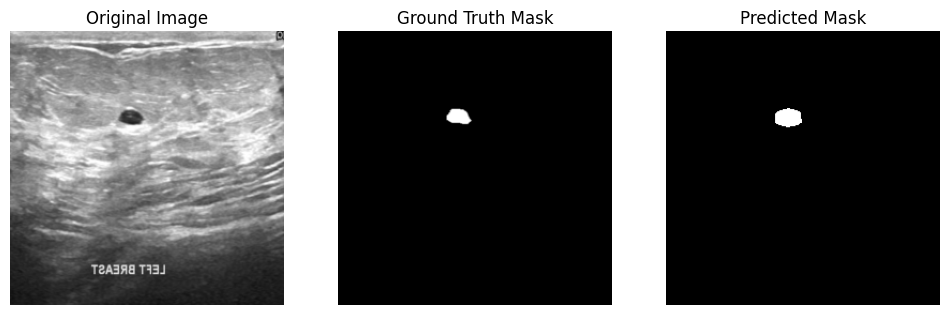

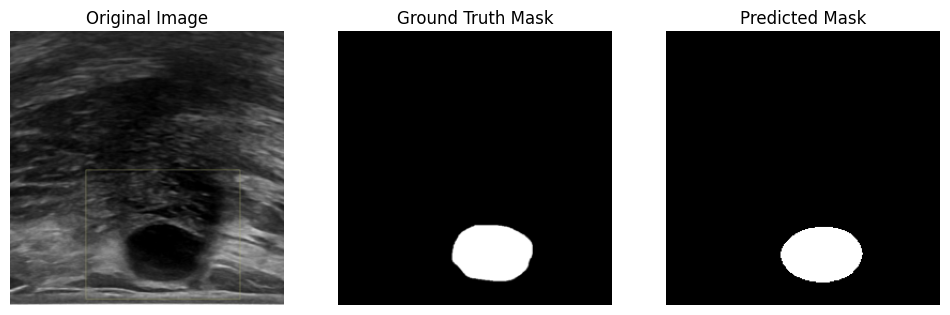

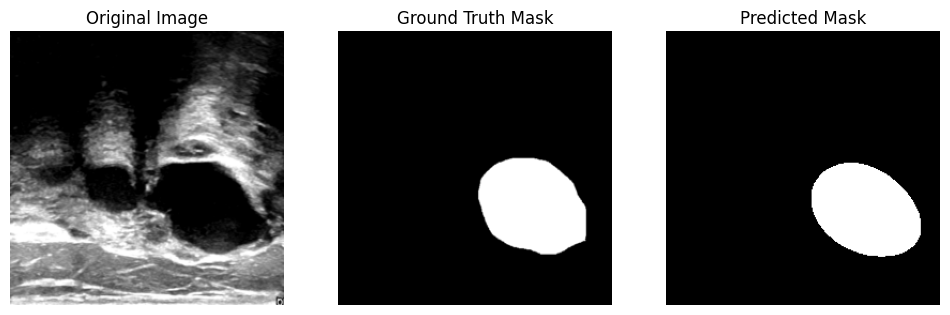

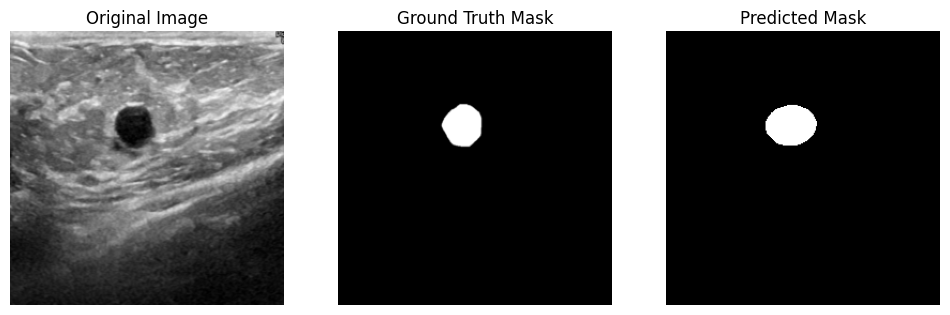

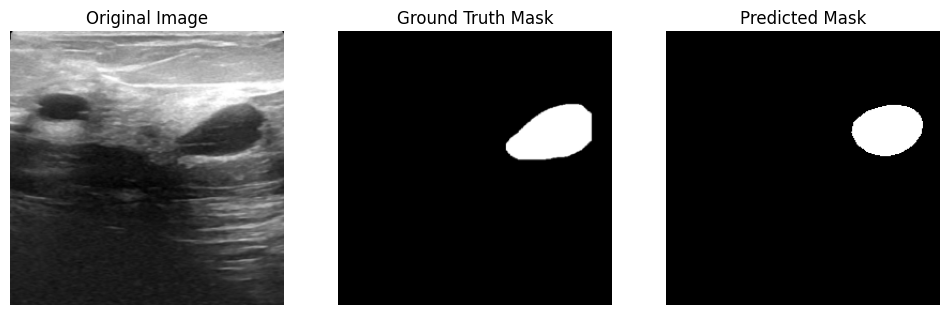

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_samples=5):
    """
    Visualize original images, ground truth masks, and predicted masks.

    Args:
    - dataset: Dataset object containing images and masks.
    - model: Trained segmentation model.
    - num_samples: Number of samples to visualize.
    """
    model.eval()  # Set model to evaluation mode

    for i in range(num_samples):
        image, mask = dataset[i]  # Get an image and its ground truth mask
        image_input = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU

        with torch.no_grad():
            # Get model prediction
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid and move to CPU
            prediction_binary = (prediction > 0.5).astype(np.uint8)  # Binarize prediction

        # Plot original image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC for plotting
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()
# Modelin tahminlerini görselleştir
visualize_predictions(dataset, model, num_samples=5)